In [1]:
import os
import pandas as pd
import scipy.stats as stats
from statsmodels.multivariate.manova import MANOVA

# 1: Read Data

## 1.1: Concatenate data into single dataframe

In [2]:
def concat_au_files(directory: str, speaking_only: bool = False):
    """
    Combines XXX_CLNF_AUs.txt files into a single DataFrame.
    When speaking_only is True, includes only rows where the participant is speaking
    based on the corresponding XXX_TRANSCRIPT.csv files.

    Args:
        directory (str): Path to the directory containing AU and transcript files.
        speaking_only (bool): Whether to include only participant-speaking rows.

    Returns:
        pd.DataFrame: Combined DataFrame of all AU files.
    """
    dfs = []

    for root, dirs, files in os.walk(directory):
        for file_name in files:
            if file_name.endswith("_CLNF_AUs.txt"):
                participant_id = file_name.split("_")[0]
    
                print(f"Reading Participant ID: {participant_id}...", end='\r')

                au_file_path = os.path.join(root, file_name)
                df = pd.read_csv(au_file_path)
                df['Participant_ID'] = participant_id  # Add Participant_ID column

                
                transcript_file = os.path.join(root, f"{participant_id}_TRANSCRIPT.csv")
                if os.path.exists(transcript_file):
                    # Load the transcript file with specific delimiters
                    transcript_df = pd.read_csv(
                        transcript_file,
                        sep=r"\s+",  # One or more whitespaces as the delimiter
                        engine="python",
                        skiprows=1,  # Skip the first header row
                        header=None,
                        usecols=[0, 1, 2],  # Only load the columns we care about
                        names=['start_time', 'stop_time', 'speaker'],
                    )

                    # If speaking_only is True, filter the rows
                    if speaking_only:
                        # Filter to include only Participant speaking rows
                        participant_speaking = transcript_df[transcript_df['speaker'] == "Participant"]

                        # Retain rows in AU data where timestamp falls within speaking intervals
                        mask = df[' timestamp'].apply(
                            lambda t: any(
                                (participant_speaking['start_time'] <= t) &
                                (t <= participant_speaking['stop_time'])
                            )
                        )
                        df = df[mask]

                    else:
                        actual_start_time = None
                        for _, row in transcript_df.iterrows():
                            start_time = row['start_time']
                            stop_time = row['stop_time'] 
                            speaker = row["speaker"]

                            if speaker == "Ellie":
                                actual_start_time = start_time
                                break

                        df = df[df[" timestamp"] >= actual_start_time]

                        

                    dfs.append(df)

    # Combine into a single DataFrame
    combined_df = pd.concat(dfs, ignore_index=True)

    return combined_df


In [3]:
df = concat_au_files("../../data/DAIC-WOZ/", speaking_only=False)

In [4]:
# Remove non-successful feature extraction rows
print(f"Unsuccessful frames in data to be removed: {(1 - df[' success'].sum() / df.shape[0]) * 100}%")
df = df[df[" success"] == 1] 

Unsuccessful frames in data to be removed: 4.817401752851014%


In [5]:
print(f"\nUnique videos: {df.Participant_ID.nunique()}")
print(f"Total processed frames: {df.shape[0]}")
print(f"Avg frames per video: {df.groupby('Participant_ID').size().mean()}")
print(f"Memory used: {df.memory_usage(deep=True).sum() / (1024 **3)} GB")


Unique videos: 186
Total processed frames: 4874871
Avg frames per video: 26208.983870967742
Memory used: 1.1804201267659664 GB


## 1.2: Clean Sessions with Special Notes

373 – there is an interruption around 5:52-7:00, the confederate enters the room to fix a minor 
technical issue, the session continuous and completes .

In [6]:
cond = (df["Participant_ID"] == "373") & (df[" timestamp"] >= 5*60 + 52) & (df[" timestamp"] <= 7*60)
df = df.drop(df[cond].index)

444 – there is an interruption around 4:46-6:27, the participant’s phone rings and the 
confederate enters the room to help them turn it off. Session continuous and completes.

In [7]:
cond = (df["Participant_ID"] == "444") & (df[" timestamp"] >= 4*60 + 46) & (df[" timestamp"] <= 6*60 + 27)
df = df.drop(df[cond].index)

In [8]:
print(f"\nUnique videos: {df.Participant_ID.nunique()}")
print(f"Total processed frames: {df.shape[0]}")
print(f"Avg frames per video: {df.groupby('Participant_ID').size().mean()}")
print(f"Memory used: {df.memory_usage(deep=True).sum() / (1024 **3)} GB")


Unique videos: 186
Total processed frames: 4870771
Avg frames per video: 26186.940860215054
Memory used: 1.1794273369014263 GB


## 1.3 Join with Split Datafarames for "Gender" and "PHQ8_Score"

In [9]:
# Read the splits CSV files
train_split_df = pd.read_csv("../../data/DAIC-WOZ/train_split_Depression_AVEC2017.csv")
validation_split_df  = pd.read_csv("../../data/DAIC-WOZ/dev_split_Depression_AVEC2017.csv")
test_split_df  = pd.read_csv("../../data/DAIC-WOZ/full_test_split.csv")
test_split_df = test_split_df.rename(columns={"PHQ_Score": "PHQ8_Score"})

In [10]:
# Combine splits data
participant_info_df = pd.concat([train_split_df , validation_split_df , test_split_df ], ignore_index=True)
participant_info_df = participant_info_df[['Participant_ID', 'Gender', 'PHQ8_Score']]
participant_info_df['Participant_ID'] = participant_info_df['Participant_ID'].astype(str)

In [11]:
# Replace PHQ8_Score with Category
def categorize_phq8(score):
    if 0 <= score <= 9:
        return '0'
    else:
        return '1'
    
participant_info_df['Category'] = participant_info_df['PHQ8_Score'].apply(categorize_phq8)
participant_info_df.drop('PHQ8_Score', axis=1, inplace=True)

In [12]:
participant_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189 entries, 0 to 188
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Participant_ID  189 non-null    object
 1   Gender          189 non-null    int64 
 2   Category        189 non-null    object
dtypes: int64(1), object(2)
memory usage: 4.6+ KB


In [19]:
participant_info_df.groupby(['Gender', 'Category']).size().reset_index(name='Count')

,Gender,Category,Count
0,0,0,56
1,0,1,31
2,1,0,76
3,1,1,26


In [13]:
df = df.merge(participant_info_df, on='Participant_ID', how='left')

print(f"\nUnique videos: {df.Participant_ID.nunique()}")
print(f"Total processed frames: {df.shape[0]}")
print(f"Avg frames per video: {df.groupby('Participant_ID').size().mean()}")
print(f"Memory used: {df.memory_usage(deep=True).sum() / (1024 **3)} GB")


Unique videos: 186
Total processed frames: 4870771
Avg frames per video: 26186.940860215054
Memory used: 1.4425304774194956 GB


## 1.4: Preview

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4870771 entries, 0 to 4870770
Data columns (total 27 columns):
 #   Column          Dtype  
---  ------          -----  
 0   frame           int64  
 1    timestamp      float64
 2    confidence     float64
 3    success        int64  
 4    AU01_r         float64
 5    AU02_r         float64
 6    AU04_r         float64
 7    AU05_r         float64
 8    AU06_r         float64
 9    AU09_r         float64
 10   AU10_r         float64
 11   AU12_r         float64
 12   AU14_r         float64
 13   AU15_r         float64
 14   AU17_r         float64
 15   AU20_r         float64
 16   AU25_r         float64
 17   AU26_r         float64
 18   AU04_c         int64  
 19   AU12_c         int64  
 20   AU15_c         int64  
 21   AU23_c         int64  
 22   AU28_c         int64  
 23   AU45_c         int64  
 24  Participant_ID  object 
 25  Gender          int64  
 26  Category        object 
dtypes: float64(16), int64(9), object(2)
memor

In [15]:
df.head()

,frame,timestamp,confidence,success,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU09_r,...,AU26_r,AU04_c,AU12_c,AU15_c,AU23_c,AU28_c,AU45_c,Participant_ID,Gender,Category
0,1099,36.6000,0.971387,1,0.0,0.0,0.0,0.707505,0.000000,0.000000,...,0.0,0,0,0,1,0,0,300,1,0
1,1100,36.6333,0.972090,1,0.0,0.0,0.0,0.750787,0.000000,0.000000,...,0.0,0,0,0,1,0,0,300,1,0
2,1101,36.6667,0.971037,1,0.0,0.0,0.0,0.641022,0.578254,0.538955,...,0.0,0,0,0,1,0,0,300,1,0
3,1102,36.7000,0.974087,1,0.0,0.0,0.0,0.640049,0.000000,0.000000,...,0.0,0,0,0,1,0,0,300,1,0
4,1103,36.7333,0.972015,1,0.0,0.0,0.0,0.620604,0.539977,0.000000,...,0.0,0,0,0,1,0,0,300,1,0


In [16]:
# Filter columns starting with 'AU'
AU_cols = df.filter(like="AU").columns
AU_cols_bin = df.filter(regex="AU\d+_c").columns
AU_cols_cont = df.filter(regex="AU\d+_r").columns

<Axes: >

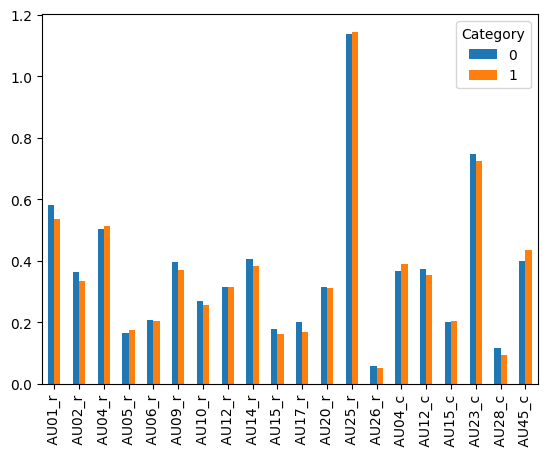

In [17]:
# Group by the extracted keys and calculate mean for AU columns
AU_means = df.groupby(['Category'])[AU_cols].mean().T

AU_means.plot(kind='bar')

# 2: Statistical Tests

## 2.1: Individual AUs

One-Way ANOVA for Continuous AUs

In [20]:
def one_way_anova(df, continuous_aus):
    results = {}
    for au_col in continuous_aus:
        groups = [df[df["Category"] == cat][au_col] for cat in df["Category"].unique()]
        f_stat, p_value = stats.f_oneway(*groups)
        results[au_col] = {"F-Statistic": f_stat, "P-Value": p_value}
    return results

# Run One-Way ANOVA
one_way_anova_results = one_way_anova(df, AU_cols_cont)

for key, values in one_way_anova_results.items():
    print(key, values)

 AU01_r {'F-Statistic': 3071.5207582835774, 'P-Value': 0.0}
 AU02_r {'F-Statistic': 2944.9170754195193, 'P-Value': 0.0}
 AU04_r {'F-Statistic': 97.58016900129321, 'P-Value': 5.1745119061718254e-23}
 AU05_r {'F-Statistic': 977.3184747194201, 'P-Value': 1.6062024689570315e-214}
 AU06_r {'F-Statistic': 176.61530758353098, 'P-Value': 2.661810778112581e-40}
 AU09_r {'F-Statistic': 2268.884867397547, 'P-Value': 0.0}
 AU10_r {'F-Statistic': 1119.024062617719, 'P-Value': 2.5828779470750155e-245}
 AU12_r {'F-Statistic': 17.007888573667053, 'P-Value': 3.722545523299194e-05}
 AU14_r {'F-Statistic': 1364.6025600987427, 'P-Value': 1.1376276257723865e-298}
 AU15_r {'F-Statistic': 1924.2111084085395, 'P-Value': 0.0}
 AU17_r {'F-Statistic': 8148.683849366347, 'P-Value': 0.0}
 AU20_r {'F-Statistic': 43.77207705737286, 'P-Value': 3.689691997198994e-11}
 AU25_r {'F-Statistic': 29.304332345703703, 'P-Value': 6.186015019304671e-08}
 AU26_r {'F-Statistic': 666.1211171063164, 'P-Value': 7.129692616936958e-14

Chi-Square for Binary AUs

In [21]:
def chi_square_for_all(df, binary_aus):
    results = {}
    for au_col in binary_aus:
        contingency_table = pd.crosstab(df[au_col], df["Category"])
        chi2_stat, p_value = stats.chi2_contingency(contingency_table)[:2]
        results[au_col] = {"Chi2-Statistic": chi2_stat, "P-Value": p_value}
    return results

# Run Chi-Square Tests
chi2_results = chi_square_for_all(df, AU_cols_bin)
 
for key, values in chi2_results.items():
    print(key, values)

 AU04_c {'Chi2-Statistic': 2404.624746453936, 'P-Value': 0.0}
 AU12_c {'Chi2-Statistic': 1806.7849208572616, 'P-Value': 0.0}
 AU15_c {'Chi2-Statistic': 17.70605308118845, 'P-Value': 2.5780492759669915e-05}
 AU23_c {'Chi2-Statistic': 2930.756955965126, 'P-Value': 0.0}
 AU28_c {'Chi2-Statistic': 5321.191151476965, 'P-Value': 0.0}
 AU45_c {'Chi2-Statistic': 6397.731014837063, 'P-Value': 0.0}


## 2.2: Multiple AUs

MANOVA for all continuous AUs at once

In [ ]:
# Run MANOVA with all AUs as dependent variables
# def run_manova(df, au_cols):
#     formula = ' + '.join(au_cols)
#     model = MANOVA.from_formula(f'{formula} ~ C(Category)', data=df)
#     return model.mv_test()

# manova_results = run_manova(df, AU_cols_cont)
# print(manova_results)

# 3. ML Testing

## 3.1 Single Category

In [22]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Function to prepare data
def prepare_time_series_data(df, au_col):
    train_data = []
    train_labels = []
    test_data = []
    test_labels = []


    for participant_id, group in df.groupby(["Participant_ID", 'Category']):
        participant_data = group[au_col].values 
        label = group["Category"].iloc[0]  # Get the category for this participant_id

        if int(participant_id[0]) in test_split_df['Participant_ID'].values:
            test_data.append(participant_data)
            test_labels.append(label)

        elif int(participant_id[0]) in train_split_df['Participant_ID'].values:
            train_data.append(participant_data)
            train_labels.append(label)

    return (
        np.array(train_data),
        np.array(test_data),
        np.array(train_labels),
        np.array(test_labels),
    )

# Prepare data
X_train, X_test, y_train, y_test = prepare_time_series_data(df, " AU14_r") # Input any AU column

# Handle potential missing data (e.g., unequal number of frames)
# Pad to the maximum input length
max_length = max([len(x) for x in np.concatenate([X_train, X_test])])
X_train = np.array([np.pad(x, (0, max_length - len(x)), constant_values=0) for x in X_train])
X_test = np.array([np.pad(x, (0, max_length - len(x)), constant_values=0) for x in X_test])

# Train a random forest classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Test the classifier
y_pred = clf.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Evaluate performance
print("Classification Report:")
print(classification_report(y_test, y_pred))

C:\Users\bryan\AppData\Local\Temp\ipykernel_8884\2325770222.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(train_data),
C:\Users\bryan\AppData\Local\Temp\ipykernel_8884\2325770222.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(test_data),


Confusion Matrix:
[[28  4]
 [14  0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.88      0.76        32
           1       0.00      0.00      0.00        14

    accuracy                           0.61        46
   macro avg       0.33      0.44      0.38        46
weighted avg       0.46      0.61      0.53        46

